# Statistical Methods in Finance Course Work
### George Coxon, David Malone, Tingqu Zhou

We first create methods for calculating Kupiec's P-value

In [20]:
import pandas as pd
import numpy as np
from scipy import stats


def log_lik(p: float, obs: pd.Series):
    """
    Likelihood ratio = -2*log(L_1/L_2)
    This function will calculate log(L_i) for any series of binomial obesrvations
    :param p: probability of success
    :param obs: Series of observations, values are 1 or 0
    """
    return obs.apply(lambda x: np.log(((1-p)**(1-x))*(p**x))).sum()


def lr_uc(alpha: float, exceeds: pd.Series):
    """
    Calculate unconditional likelihood ratio statistic for any series of binomial obesrvations
    :param alpha: confidence level between 0 and 1
    :param exceeds: Series of booleans/ints, indicating if the event happened
    """
    # calc pi_hat MLE
    obs = exceeds.astype(int)
    pi_hat = np.mean(obs)

    # return LR_UC for pi_hat and 1-alpha
    return -2*(log_lik(1-alpha, obs)-log_lik(pi_hat, obs))


def p_chi2(x: float, dof: int = 1):
    """
    Calculate the p value for a chi2 distrubution
    :param x: test statistic value
    :param dof: Degrees of freedom for chi2 ist
    """
    return 1-stats.chi2.cdf(x, dof)

We now create classes for each distribution

In [21]:
import matplotlib.pyplot as plt

from scipy.optimize import minimize
import scipy.stats as stats
from scipy.special import hyp2f1, beta
from scipy.integrate import quad
from scipy.optimize import minimize_scalar

from abc import ABC, abstractmethod
from typing import Iterable

In [23]:
class Distribution(ABC):
    def __init__(self) -> None:

        self.sol = None
        self.name: str = None
        self.num_parameters: int = None
        self.parameters: str = None
        self.sample_size: int = None
        self.data: pd.DataFrame = None
        return

    @abstractmethod
    def log_likelihood(x: float, *dist_params: float) -> float:
        """
        Calculate log likelihood of observing x, given a distrubution 
        with these parameters.
        """
        pass

    @abstractmethod
    def pdf(x: float) -> float:
        """
        Return value of probability density function evaluated at x.
        """
        pass

    def cdf(self, x: float) -> float:
        """
        Integrate the pdf function to return Cumulative Distribution value
        """
        mu = self.data.mean()
        std = self.data.std()

        output = quad(lambda x: self.pdf(x, *self.sol.x), mu-20*std, x)
        return output[0]

    def quantile(self, alpha: float) -> float:
        """
        Return inverse cdf for distrubution.
        Inverse is found by root finding (cdf(x)-alpha)^2
        """
        return minimize_scalar(lambda x: (self.cdf(x)-alpha)**2).x

    def expected_shortfall(self, alpha: float) -> float:
        """
        Calculate expected shortfall by integrating xf(x)
        +inf is replace with mu+20*std for efficiency
        """
        mu = self.data.mean()
        std = self.data.std()
        integral = quad(lambda x: x * self.pdf(x, *self.sol.x),
                        self.quantile(alpha), mu+20*std)

        return integral[0]/(1-alpha)

    def print_params(self):
        """
        Print out distrubution parameter names and values
        """
        for idx, param in enumerate(self.parameters):
            print(f"{param}: {self.sol.x[idx]}")

        return

    def info_dict(self) -> dict:
        """
        Return information dict about the quality of distrubition fit.
        Quality of fit is measured by the following metrics:
        - AIC
        - AICC
        - BIC
        - CAIC
        - HQC
        """

        info_dict = {'dist': self.name,
                     'LL': self.sol.fun, 'AIC': self.aic(),
                     'AICC': self.aicc(), 'BIC': self.bic(),
                     'CAIC': self.caic(), 'HQC': self.hqc(),
                     'pydist': self
                     }

        return info_dict

    def plot_dist(self, ax: plt.Axes = None) -> plt.Axes:
        """
        Plot observed data and density of distrubutio fit
        """
        if ax is None:
            _, ax = plt.subplots(1, 1)

        mu = self.data.mean()
        std = self.data.std()

        linspace = np.linspace(mu-4*std, mu+4*std, 101)

        ax.hist(self.data.values, bins=50, density=True)
        density = self.pdf(linspace, *self.sol.x)

        ax.plot(linspace, density)
        ax.set_title(f"{self}")

        return ax

    def kupic_plot(self, quantiles: Iterable[float], ax: plt.Axes = None) -> plt.Axes:

        # Calculate value at risk for each quantile
        vars = [self.quantile(quantile) for quantile in quantiles]

        p_vals = []

        for alpha, var in zip(quantiles, vars):

            # get p value for each quantile based on
            # observed and expected var exceedances
            viol_mask = (self.data > var)
            likelihood_uc = lr_uc(alpha, viol_mask)
            p_val_uc = p_chi2(likelihood_uc)
            p_vals.append(p_val_uc)

        if ax is None:
            _, ax = plt.subplots(1, 1)

        ax.plot(quantiles, p_vals, color='k')
        ax.axhline(0.05, color='r')

        return ax

    @abstractmethod
    def mle(self, x):
        """
        Fit parameters of the distrubution using maximum likelihood estimation
        """
        self.sample_size = x.shape[0]
        self.data = x

    def __repr__(self) -> str:
        if self.sol is None:
            repr_str = f"{self.name} - Unfit"
        else:
            repr_str = f"{self.name}("

            param_list = []
            for p_name, p in zip(self.parameters, self.sol.x):
                param_list.append(f"{p_name}={p:.3f}")

            repr_str = f"{repr_str}{', '.join(param_list)})"

        return repr_str

    def aic(self) -> float:
        """
        The AIC of an MLE estiamte equals 2*number of parameters - value of loglikelihood
        Inputs:
        k-number of parameters in distribution
        L-the value of the loglikelihood function
        """
        return 2*self.num_parameters + 2*self.sol.fun

    def bic(self) -> float:
        """
        The BIC of an MLE estiamte equals #parameters * log(sample size) - 2 * value of loglikelihood
        Inputs:
        k-number of parameters in distribution
        L-the value of the loglikelihood function
        """
        return self.num_parameters*np.log(self.sample_size) + 2*self.sol.fun

    def caic(self) -> float:
        """
        The BIC of an MLE estiamte equals #parameters * (log(sample size)+1) - 2 * value of loglikelihood
        Inputs:
        k-number of parameters in distribution
        L-the value of the loglikelihood function
        """
        return self.num_parameters*(np.log(self.sample_size)+1) + 2*self.sol.fun

    def aicc(self) -> float:
        """
        Corrected Akaike information criterion
        """
        k = self.num_parameters
        n = self.sample_size

        return self.aic() + 2*k*(k+1)/(n-k-1)

    def hqc(self) -> float:
        """
        Hannan-Quinn criterion
        """
        k = self.num_parameters
        n = self.sample_size

        return 2*self.sol.fun + 2*k*np.log(np.log(n))

    def kol_smir(self) -> float:
        """
        Kolmogorov-Smirnov test
        """
        cdfdata = list(map(self.cdf, self.data))
        return stats.kstest(self.data, cdfdata)

    def kappa(self, nu: float) -> float:
        """
        Kappa function used in density of many child distrubutions
        """
        return 1/(np.sqrt(nu)*beta(nu/2, 1/2))


class Laplace(Distribution):

    def __init__(self) -> None:
        super().__init__()
        self.num_parameters = 2
        self.parameters = ['mu', 'b']
        self.name = 'Laplace'

    @staticmethod
    def pdf(x, mu, b):
        return np.exp(-np.abs(x-mu)/b)/(2*b)

    def log_likelihood(self, x, mu, b):
        return np.sum(np.log(self.pdf(x, mu, b)))

    def mle(self, x):
        super().mle(x)
        def objfun(theta): return -1*self.log_likelihood(x, *theta)
        bnds = ((-np.inf, np.inf), (1e-15, np.inf))  # bounds on parameters

        init_theta = [np.mean(x), 1]

        sol = minimize(objfun, init_theta, method='Nelder-Mead', bounds=bnds)
        self.sol = sol

        return sol.x


class StudentT(Distribution):

    def __init__(self) -> None:

        super().__init__()
        self.num_parameters = 3
        self.parameters = ['mu', 'sigma', 'nu']
        self.name = 'Student T'

    def pdf(self, x, mu, sigma, nu):
        return (self.kappa(nu)/sigma) * (1 + ((x-mu)**2)/(nu * sigma**2))**(-(1+nu)/2)

    def log_likelihood(self, x, mu, sigma, nu):
        return np.sum(np.log(self.pdf(x, mu, sigma, nu)))

    def mle(self, x):
        super().mle(x)
        def objfun(theta): return -1*self.log_likelihood(x, *theta)

        bnds = ((-np.inf, np.inf), (0, np.inf), (0, np.inf))
        init_theta = [np.mean(x), 0.05, 1]

        sol = minimize(objfun, init_theta, method='Nelder-Mead', bounds=bnds)
        self.sol = sol

        return sol


class GeneralizedT(Distribution):

    def __init__(self) -> None:

        super().__init__()
        self.num_parameters = 4
        self.parameters = ['mu', 'sigma', 'nu', 'tau']
        self.name = 'Generalized T'

    @staticmethod
    def pdf(x, mu, sigma, nu, tao):
        return (tao / (2*sigma*nu**(1/tao) * beta(nu, 1/tao)))*(1 + 1/nu * np.abs((x-mu)/sigma)**tao)**(-(nu+1/tao))

    def log_likelihood(self, x, mu, sigma, nu, tao):
        return np.sum(np.log(self.pdf(x, mu, sigma, nu, tao)))

    def mle(self, x):
        super().mle(x)
        def objfun(theta): return -1*self.log_likelihood(x, *theta)

        bnds = ((-np.inf, np.inf), (0.001, np.inf), (0.001, np.inf),
                (0.001, np.inf))  # bounds on parameters

        init_theta = [np.mean(x), np.std(x, ddof=1), 1, 1]

        sol = minimize(objfun, init_theta, method='Nelder-Mead', bounds=bnds)
        self.sol = sol

        return sol


class NormalizedInverseGaussian(Distribution):
    """
    There is a normal inverse gaussian pdf function in scipy, which references the same source as the paper
    with  a = alpha * delta, b = beta * delta, loc = mu, scale=delta according to scipy documentation
    There is a requirement in scipy that |beta|<=alpha, this corresponds to |beta|<alpha, which isn't stated explicitly in the paper
    but is a requirement in order to ensure their paramter gamma=sqrt(alpha**2-beta**2) is real
    """

    def __init__(self) -> None:

        super().__init__()
        self.num_parameters = 4
        self.parameters = ['mu', 'delta', 'alpha', 'beta']
        self.name = 'Normalized Inverse Gaussian'

    @staticmethod
    def pdf(x, mu, delta, alpha, beta):
        return stats.norminvgauss.pdf(x, a=alpha*delta, b=beta*delta, loc=mu, scale=delta)

    def log_likelihood(self, x, mu, delta, alpha, beta):
        return np.sum(np.log(self.pdf(x, mu, delta, alpha, beta)))

    def mle(self, x):
        super().mle(x)
        def objfun(theta): return -1*self.log_likelihood(x, *theta)

        bnds = ((-np.inf, np.inf), (0.01, np.inf), (0.01, np.inf),
                (0.01, np.inf))  # bounds on parameters

        # inequality constraint alpha-beta>0 equivalent to alpha>beta
        def constraint(theta): return theta[2]-theta[3]

        con = {'type': 'ineq', 'fun': constraint}

        init_theta = [np.mean(x), np.std(x, ddof=1), 1, 0.5]

        sol = minimize(objfun, init_theta, method='Nelder-Mead',
                       bounds=bnds, constraints=con)
        self.sol = sol

        return sol


class GeneralizedHyperbolic(Distribution):

    def __init__(self) -> None:

        super().__init__()
        self.num_parameters = 5
        self.parameters = ['mu', 'delta', 'lambda', 'alpha', 'beta']
        self.name = 'Generalized Hyperbolic'

    @staticmethod
    def pdf(x, mu, delta, lmda, alpha, beta):
        return stats.genhyperbolic.pdf(x, p=lmda, a=delta*alpha, b=beta*delta, scale=delta, loc=mu)

    def log_likelihood(self, x, mu, delta, lmda, alpha, beta):
        return np.sum(np.log(self.pdf(x, mu, delta, lmda, alpha, beta)))

    def mle(self, x):
        super().mle(x)
        def objfun(theta): return -1*self.log_likelihood(x, *theta)

        bnds = ((-np.inf, np.inf), (0.01, np.inf), (-np.inf, np.inf),
                (0.01, np.inf), (0.01, np.inf))  # bounds on parameters

        # inequality constraint alpha-beta>0 equivalent to alpha>beta
        def constraint(theta): return theta[3]-theta[4]

        con = {'type': 'ineq', 'fun': constraint}

        init_theta = [np.mean(x), np.std(x, ddof=1), 1, 1, 0.5]

        sol = minimize(objfun, init_theta, method='Nelder-Mead',
                       bounds=bnds, constraints=con)
        self.sol = sol

        return sol


class SkewT(Distribution):

    def __init__(self) -> None:

        super().__init__()
        self.num_parameters = 4
        self.parameters = ['mu', 'sigma', 'nu', 'lambda']
        self.name = 'Skew T'

    @staticmethod
    def pdf(x, mu, sigma, nu, lmda):
        output = (2/sigma)*stats.t.pdf((x-mu)/sigma, df=nu) *\
            stats.t.cdf((lmda * (x-mu)/sigma) *
                        np.sqrt((nu+1) / (((x-mu)/sigma)**2 + nu)), df=nu+1)

        return output

    def log_likelihood(self, x, mu, sigma, nu, lmda):
        return np.sum(np.log(self.pdf(x, mu, sigma, nu, lmda)))

    def mle(self, x):
        super().mle(x)
        def objfun(theta): return -1*self.log_likelihood(x, *theta)

        bnds = ((-np.inf, np.inf), (1e-15, np.inf), (1e-15, np.inf),
                (-np.inf, np.inf))  # bounds on parameters

        init_theta = [np.mean(x), np.std(x, ddof=1), 1, 1]

        sol = minimize(objfun, init_theta, method='Nelder-Mead', bounds=bnds)
        self.sol = sol

        return sol


class SkewedStudent(Distribution):

    def __init__(self) -> None:

        super().__init__()
        self.num_parameters = 4
        self.parameters = ['mu', 'sigma', 'nu', 'alpha']
        self.name = 'Skewed Student T'

    def pdf(self, x, mu, sigma, nu, alpha):
        indicator = (x > mu)*1  # switch on if x is greater than mu
        output = (self.kappa(nu)/sigma) *\
            (1+(1/nu)*((x-mu)/(2*sigma*(alpha*(1-indicator) + (1-alpha)*indicator)))**2)**(-(nu+1)/2)
        return output

    def log_likelihood(self, x, mu, sigma, nu, alpha):
        return np.sum(np.log(self.pdf(x, mu, sigma, nu, alpha)))

    def mle(self, x):
        super().mle(x)
        def objfun(theta): return -1*self.log_likelihood(x, *theta)

        bnds = ((-np.inf, np.inf), (1e-15, np.inf), (1e-15, np.inf),
                (-np.inf, np.inf))  # bounds on parameters

        init_theta = [np.mean(x), np.std(x, ddof=1), 1, 0.5]

        sol = minimize(objfun, init_theta, method='Nelder-Mead', bounds=bnds)
        self.sol = sol

        return sol


class AsymmetricStudentT(Distribution):

    def __init__(self) -> None:

        super().__init__()
        self.num_parameters = 5
        self.parameters = ['mu', 'sigma', 'nu1', 'nu2', 'alpha']
        self.name = 'Asymmetric Student T'

    def pdf(self, x, mu, sigma, nu1, nu2, alpha):
        indicator = (x > mu)*1  # switch on if x is greater than mu

        alpha2 = alpha*self.kappa(nu1)/(alpha *
                                        self.kappa(nu1)+(1-alpha)*self.kappa(nu2))

        nu_indicator = nu1*(1-indicator) + nu2*indicator

        output = ((alpha/alpha2*(1-indicator) + (1-alpha)/(1-alpha2)*indicator) * self.kappa(nu_indicator)/sigma *
                  (1+1/nu_indicator*((x-mu)/(2*sigma*(alpha2*(1-indicator) + (1-alpha2)*indicator)))**2)**(-(nu_indicator+1)/2))
        return output

    def log_likelihood(self, x, mu, sigma, nu1, nu2, alpha):
        return np.sum(np.log(self.pdf(x, mu, sigma, nu1, nu2, alpha)))

    def mle(self, x):
        super().mle(x)
        def objfun(theta): return -1*self.log_likelihood(x, *theta)

        bnds = ((-np.inf, np.inf), (0.001, np.inf), (0.001, np.inf),
                (0.001, np.inf), (0.01, 0.99))  # bounds on parameters

        init_theta = [np.mean(x), np.std(x, ddof=1), 1, 1, 0.5]

        sol = minimize(objfun, init_theta, method='Nelder-Mead', bounds=bnds)

        self.sol = sol
        return sol

In [24]:
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

from datetime import timedelta, datetime
#import backtesting as bt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

from copy import copy
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

### Create data for analysis

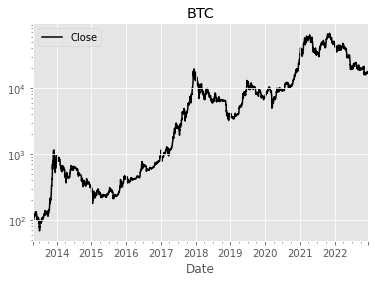

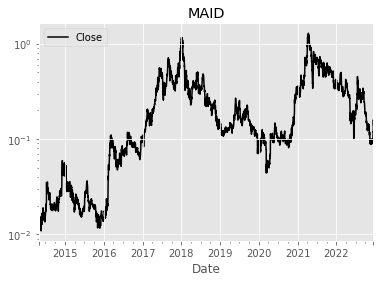

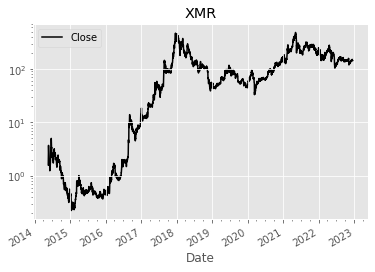

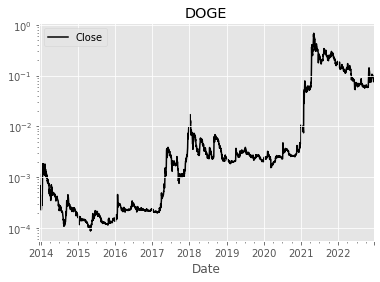

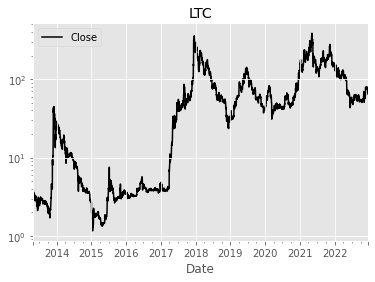

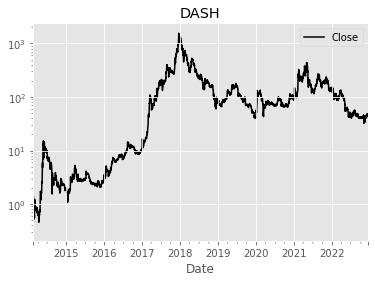

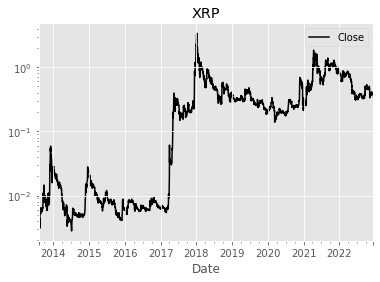

In [25]:
coins = ['BTC', 'MAID', 'XMR', 'DOGE', 'LTC', 'DASH', 'XRP']
dfs = dict()
for coin in coins:
    df = pd.read_csv(
        f'https://raw.githubusercontent.com/georgec123/sa_cw/main/data/prices/{coin}.csv').set_index('Date').sort_index()
    df.index = pd.to_datetime(df.index)
    df['log_return'] = -np.log(1 + df['Close'].pct_change())
    dfs[coin.lower()] = df.dropna()
    months = mdates.MonthLocator((1, 4, 7, 10))
    
    ax = plt.subplot()
    ax = df[['Close']].plot(ax=ax,logy=True, color='k', zorder=-10)
    
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.tick_bottom()
    
    plt.title(coin)
    plt.show()


best_dists = {
    'MAID': 'Laplace',
    'BTC': 'Generalized Hyperbolic',
    'DASH': 'Normalized Inverse Gaussian',
    'XRP': 'Normalized Inverse Gaussian',
    'XMR': 'Normalized Inverse Gaussian',
    'LTC': 'Generalized Hyperbolic',
    'DOGE': 'Generalized T'
}


### Fit models to all data

In [26]:
dists = [Laplace, SkewT, SkewedStudent, GeneralizedT,
         NormalizedInverseGaussian, GeneralizedHyperbolic, StudentT,
         AsymmetricStudentT]

end_date = pd.to_datetime('28-02-2017', format='%d-%m-%Y')
start_date = pd.to_datetime('23-06-2014', format='%d-%m-%Y')

info_list = []

for coin in coins:
    coin_df = dfs[coin.lower()]
    df = coin_df[(coin_df.index >= start_date) & (coin_df.index <= end_date)]
    for dist in dists:

        fitted_dist = dist()
        fitted_dist.mle(df['log_return'])
        info_dict = fitted_dist.info_dict()
        info_dict['coin'] = coin

        info_list.append(info_dict)
info_df = pd.DataFrame(info_list)


In [27]:
info_df

,dist,LL,AIC,AICC,BIC,CAIC,HQC,pydist,coin
0,Laplace,-2206.992043,-4409.984086,-4409.971828,-4400.204903,-4398.204903,-4406.264039,"Laplace(mu=-0.001, b=0.019)",BTC
1,Skew T,-2223.013006,-4438.026013,-4437.985071,-4418.467648,-4414.467648,-4430.585919,"Skew T(mu=-0.001, sigma=0.014, nu=1.819, lambd...",BTC
2,Skewed Student T,-2223.143401,-4438.286802,-4438.245860,-4418.728437,-4414.728437,-4430.846708,"Skewed Student T(mu=-0.001, sigma=0.014, nu=1....",BTC
3,Generalized T,-2234.276153,-4460.552307,-4460.511365,-4440.993941,-4436.993941,-4453.112213,"Generalized T(mu=-0.001, sigma=0.014, nu=5.190...",BTC
4,Normalized Inverse Gaussian,-2217.874722,-4427.749445,-4427.708503,-4408.191079,-4404.191079,-4420.309351,"Normalized Inverse Gaussian(mu=-0.001, delta=0...",BTC
5,Generalized Hyperbolic,-2234.026637,-4458.053274,-4457.991798,-4433.605317,-4428.605317,-4448.753156,"Generalized Hyperbolic(mu=-0.001, delta=0.010,...",BTC
6,Student T,-2222.967147,-4439.934294,-4439.909754,-4425.265520,-4422.265520,-4434.354223,"Student T(mu=-0.001, sigma=0.014, nu=1.823)",BTC
7,Asymmetric Student T,-2225.048536,-4440.097072,-4440.035596,-4415.649115,-4410.649115,-4430.796954,"Asymmetric Student T(mu=0.000, sigma=0.014, nu...",BTC
8,Laplace,-1315.874382,-2627.748764,-2627.736506,-2617.969581,-2615.969581,-2624.028717,"Laplace(mu=-0.000, b=0.048)",MAID
9,Skew T,-1320.266033,-2632.532067,-2632.491125,-2612.973702,-2608.973702,-2625.091973,"Skew T(mu=0.007, sigma=0.047, nu=3.466, lambda...",MAID


In [28]:
best_query = ' or '.join([f" (coin=='{coin}' and dist=='{dist}') " for coin, dist in best_dists.items()])

out_df = info_df.query(best_query)
out_df = out_df.rename(columns={'dist':'Dist', 'coin':'Coin'}).drop(columns='pydist')
out_df = out_df[['Coin', 'Dist', 'LL', 'AIC', 'AICC', 'BIC', 'CAIC', 'HQC']]
out_df[[ 'LL', 'AIC', 'AICC', 'BIC', 'CAIC', 'HQC']] =  out_df[['LL', 'AIC', 'AICC', 'BIC', 'CAIC', 'HQC']].astype(int)

for idx, row in out_df.iterrows():
    print(' & '.join(map(str,row.tolist()))+' \\\ \hline')

BTC & Generalized Hyperbolic & -2234 & -4458 & -4457 & -4433 & -4428 & -4448 \\ \hline
MAID & Laplace & -1315 & -2627 & -2627 & -2617 & -2615 & -2624 \\ \hline
XMR & Normalized Inverse Gaussian & -1302 & -2596 & -2596 & -2577 & -2573 & -2589 \\ \hline
DOGE & Generalized T & -1789 & -3571 & -3571 & -3551 & -3547 & -3564 \\ \hline
LTC & Generalized Hyperbolic & -2030 & -4051 & -4051 & -4027 & -4022 & -4042 \\ \hline
DASH & Normalized Inverse Gaussian & -1548 & -3088 & -3088 & -3068 & -3064 & -3080 \\ \hline
XRP & Normalized Inverse Gaussian & -1902 & -3797 & -3797 & -3778 & -3774 & -3790 \\ \hline


### ACF plots show no serial correlation

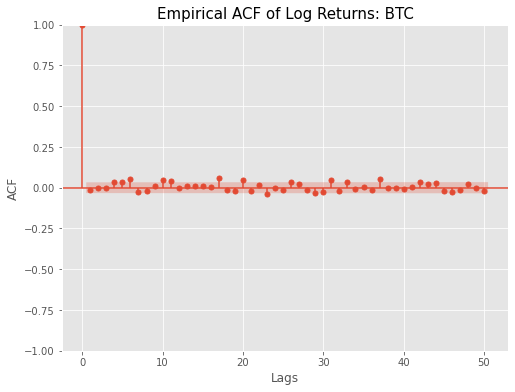

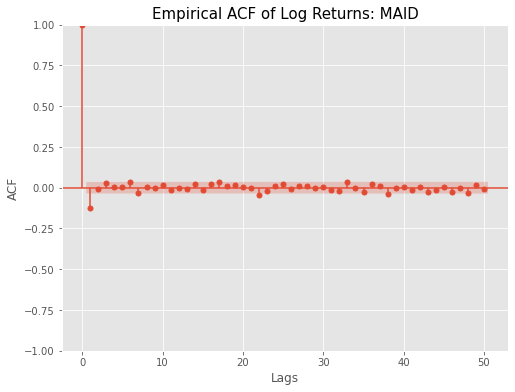

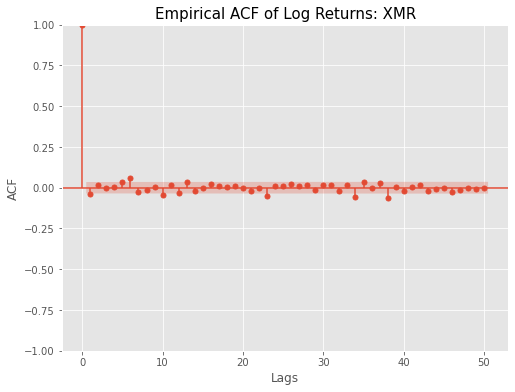

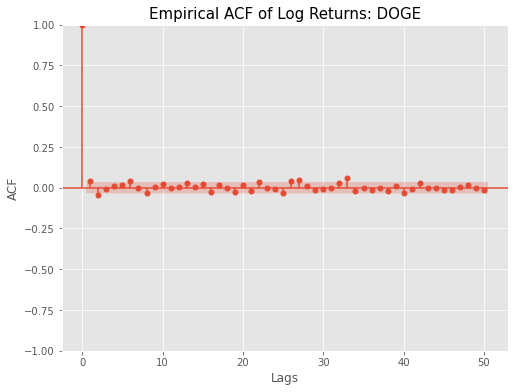

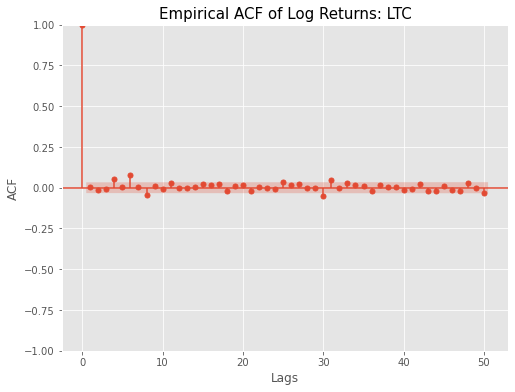

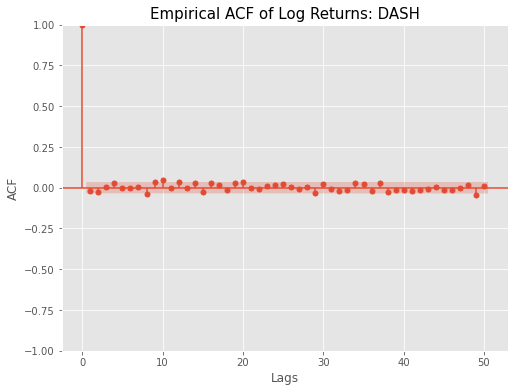

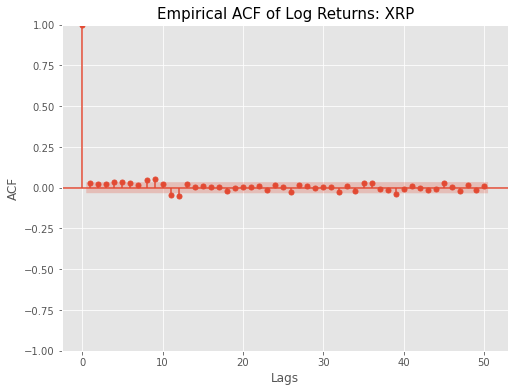

In [29]:
for coin in coins:
    fig, ax = plt.subplots(figsize=(8, 6))
    sm.graphics.tsa.plot_acf(dfs[coin.lower()]['log_return'].dropna(
    ), lags=50, title="Empricial ACF of log returns", ax=ax)
    plt.title(f'Empirical ACF of Log Returns: {coin}', size=15)
    plt.xlabel("Lags", size=12)
    plt.ylabel("ACF", size=12)
    #plt.savefig(f'../plots/acf/{coin}_acf.eps')
    plt.show()


### Breusch-Pegan Test to show no evidence of Heteroskedasticity

In [30]:
f = 'log_return ~ Date'
end_date = pd.to_datetime('28-02-2017', format='%d-%m-%Y')
start_date = pd.to_datetime('23-06-2014', format='%d-%m-%Y')

for coin in coins:
    df_coin = dfs[coin.lower()]
    df_to_fit = df_coin[(df_coin.index >= start_date)
                        & (df_coin.index <= end_date)]
                        
    f_model = ols(formula=f, data=df_to_fit.reset_index()).fit()
    test_result = sms.het_breuschpagan(f_model.resid, f_model.model.exog)

    lms, p_val, _, _ = test_result
    names = ['Lagrange multiplier statistic', 'p-value']
    print(f"{coin}: Lagrange multiplier statistic - {lms}. P-value {p_val:.4f}")


BTC: Lagrange multiplier statistic - 982.0. P-value 0.4850
MAID: Lagrange multiplier statistic - 982.0. P-value 0.4850
XMR: Lagrange multiplier statistic - 982.0. P-value 0.4850
DOGE: Lagrange multiplier statistic - 982.0. P-value 0.4850
LTC: Lagrange multiplier statistic - 982.0. P-value 0.4850
DASH: Lagrange multiplier statistic - 982.0. P-value 0.4850
XRP: Lagrange multiplier statistic - 982.0. P-value 0.4850


### Add qq plots


In [14]:
def qqplot(pydist):
    qs = list(np.linspace(0.01, 0.25, 12)) + \
        list(np.linspace(0.26, 0.75, 10))+list(np.linspace(0.76, 0.99, 12))

    quantiles = []
    for i in qs:
        q = pydist.quantile(i)
        quantiles.append(q)

    observed_quantiles = np.quantile(pydist.data.dropna().values, qs)
    _min = min(min(observed_quantiles), min(quantiles))
    _max = max(max(observed_quantiles), max(quantiles))
    fig, ax = plt.subplots()
    ax.scatter(quantiles, observed_quantiles)
    ax.set_aspect('equal', adjustable='box')

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

    ax.set_ylabel('Obseved quantiles')
    ax.set_xlabel('Theoretical quantiles')

    return fig, ax



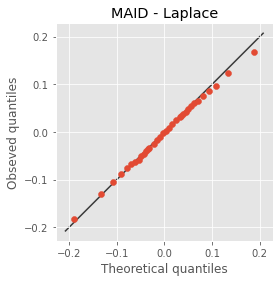

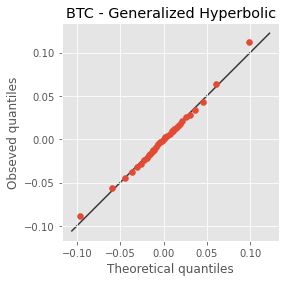

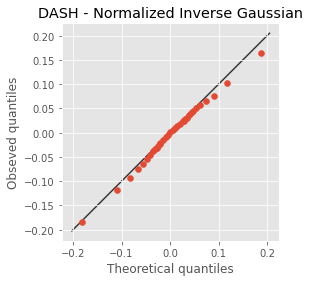

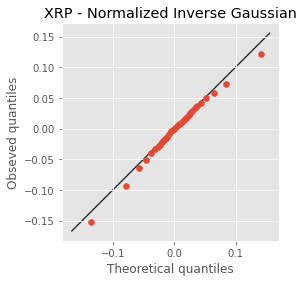

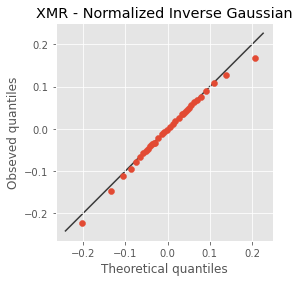

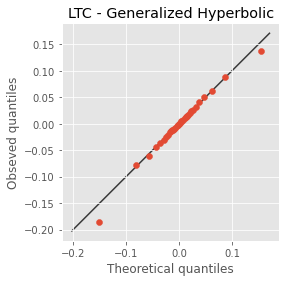

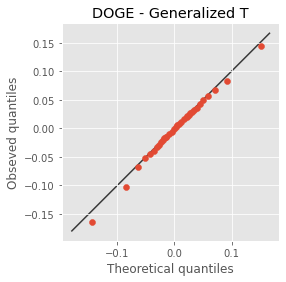

In [15]:

for coin, dist in best_dists.items():

    pydist = info_df[(info_df['coin'] == coin) & (
        info_df['dist'] == dist)]['pydist'].iloc[0]

    fig, ax = qqplot(pydist)
    ax.set_title(f"{coin} - {pydist.name}")
    #plt.savefig(f'../plots/qq/{coin}_qq.eps')
    plt.show()


### Analyse fit stability over time 

- Calculate fit parameters over a rolling window
- Plot data and save to file

In [ ]:
# ~ 9m runtime

info_list = []
jump = 90
start_to_end_days = 981

start_date = pd.to_datetime('23-06-2014', format='%d-%m-%Y')
end_date = start_date + timedelta(days=start_to_end_days)


while end_date <= datetime.now():

    for coin in coins:
        coin_df = dfs[coin.lower()]
        df = coin_df[(coin_df.index >= start_date)
                     & (coin_df.index <= end_date)]
        # df = coin_df
        for dist in dists:

            fitted_dist = dist()
            fitted_dist.mle(df['log_return'])
            info_dict = fitted_dist.info_dict()
            info_dict['coin'] = coin
            info_dict['start_date'] = start_date
            info_dict['end_date'] = end_date

            info_list.append(info_dict)

    start_date = start_date + timedelta(days=jump)
    end_date = start_date + timedelta(days=start_to_end_days)
params_over_time = pd.DataFrame(info_list)


for coin in coins:

    tmp = params_over_time[params_over_time['coin'] == coin]
    tmp = tmp[['end_date', 'dist', 'AIC']].set_index('end_date')
    tmp = tmp.pivot(columns='dist')

    tmp.columns = [col[1] for col in tmp.columns]

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

    ax1 = tmp.plot(ax=ax1)
    ax1.set_title(f"{coin.upper()}")
    ax1.set_ylabel('AIC')
    ax2.set_xlabel('')

    ax1.legend(loc=2, fontsize=8)

    ax2 = tmp.rank(axis=1).plot(ax=ax2)
    ax2.set_ylabel('Ranking')
    ax2.set_xlabel('End Date')
    ax2.get_legend().remove()

    #plt.savefig(f'../plots/fit_over_time/{coin}.eps')
    plt.show()


### Kupiec’s plots

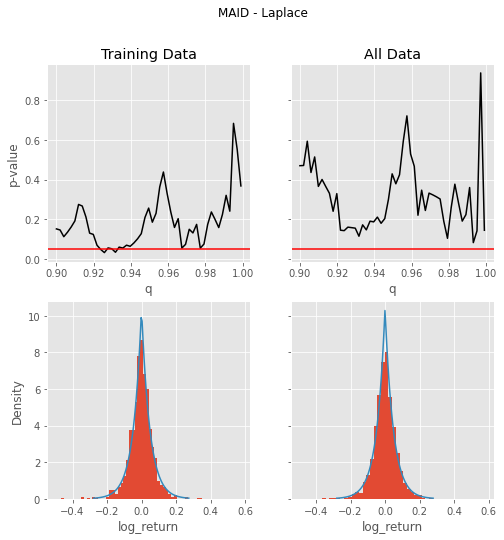

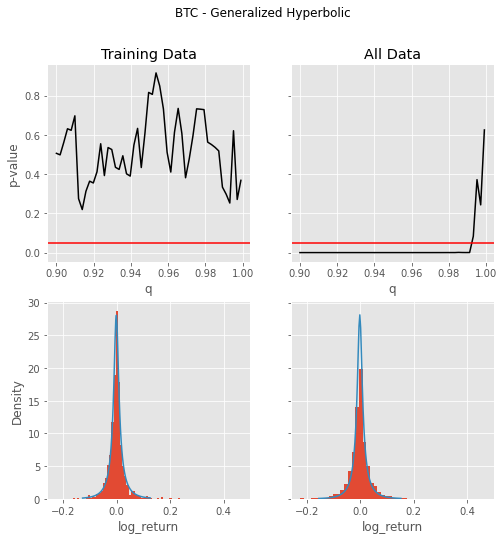

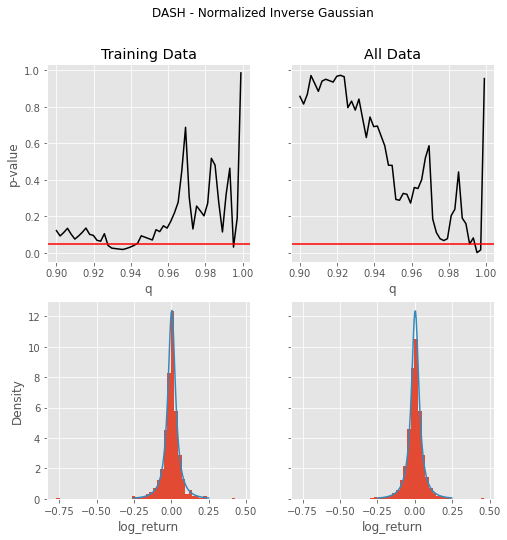

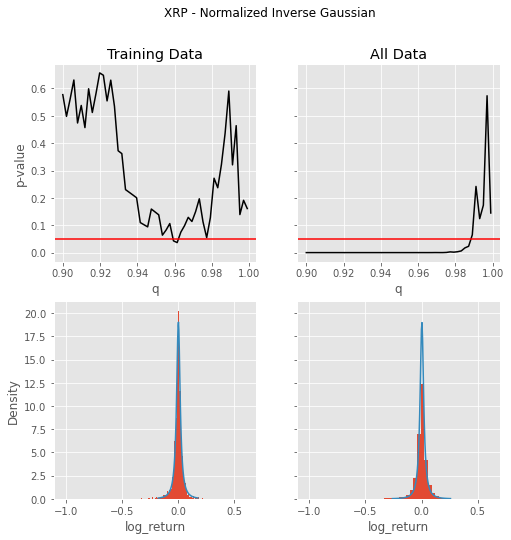

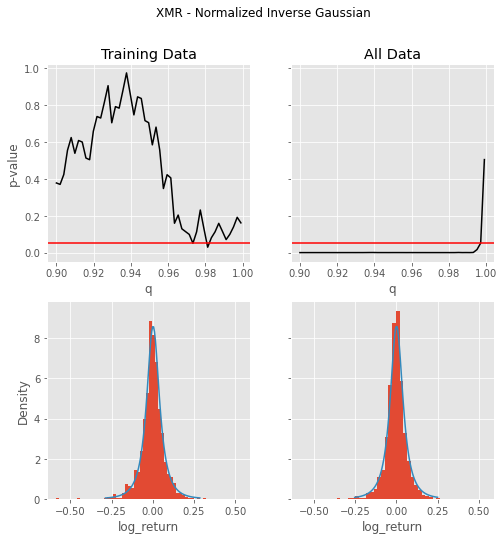

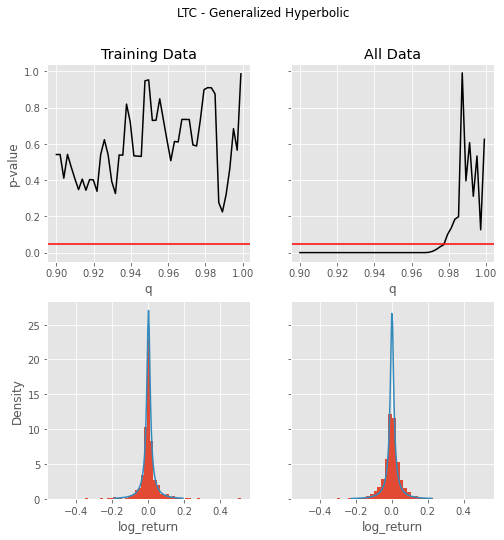

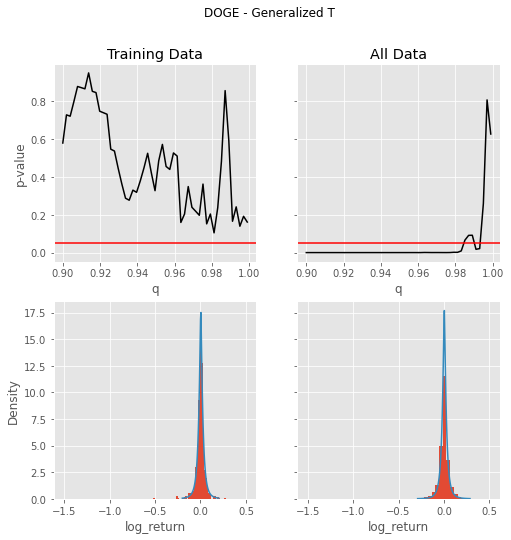

In [31]:
quantiles = np.linspace(0.9, 0.999, 51)

for coin, dist in best_dists.items():
    pydist = info_df[(info_df['coin'] == coin) & (
        info_df['dist'] == dist)]['pydist'].iloc[0]
    
    fig, axs = plt.subplots(2,2, sharey='row', sharex='row', figsize=(8,8))
    
    axs[0][0] = pydist.kupic_plot(quantiles=quantiles, ax=axs[0][0])
    
    fig.suptitle(f"{coin} - {dist}")
    
    dist_copy = copy(pydist)

    df = dfs[coin.lower()]
    df = df[df.index>=start_date]
    
    dist_copy.data = df['log_return']

    axs[0][1] = dist_copy.kupic_plot(quantiles=quantiles, ax=axs[0][1])
    
    axs[0][0].set_ylabel("p-value")
    axs[1][0].set_ylabel("Density")

    axs[0][1].set_xlabel("q")
    axs[0][0].set_xlabel("q")

    axs[1][1].set_xlabel("log_return")
    axs[1][0].set_xlabel("log_return")

    pydist.plot_dist(ax=axs[1][0])
    dist_copy.plot_dist(ax=axs[1][1])

    axs[1][0].set_title('')
    axs[1][1].set_title('')

    axs[0][0].set_title('Training Data')
    axs[0][1].set_title('All Data')

    #plt.savefig(f"../plots/kupiec/{coin}_alldata.eps")
    
    plt.show()
    
    


## K-S Test

In [32]:
p_vals = []

for coin, dist in best_dists.items():

    # get pydist
    pydist = info_df[(info_df['coin'] == coin) & (
        info_df['dist'] == dist)]['pydist'].iloc[0]

    df = dfs[coin.lower()]
    df = df[df.index >= start_date]
    df['log_return']

    # vectorise cdf so it works with scipy ks
    def cdf(x): return np.vectorize(pydist.cdf)(x)

    ks_insample = stats.kstest(pydist.data.values, cdf,)
    ks_outsample = stats.kstest(
        df['log_return'].values, cdf,alternative='greater')

    print(f"{coin} - pval (insample): {ks_insample.pvalue:.5f}. "
          f"pval (out of sample): {ks_outsample.pvalue:.5f}")


MAID - pval (insample): 0.65692. pval (out of sample): 0.12261
BTC - pval (insample): 0.62984. pval (out of sample): 0.00000
DASH - pval (insample): 0.46666. pval (out of sample): 0.00019
XRP - pval (insample): 0.42970. pval (out of sample): 0.00000
XMR - pval (insample): 0.96326. pval (out of sample): 0.00000
LTC - pval (insample): 0.98532. pval (out of sample): 0.00000
DOGE - pval (insample): 0.71559. pval (out of sample): 0.00000


## VaR plots

In [33]:
q = np.linspace(0.01, 0.99, 101)

#euro = pd.read_csv('../data/prices/EURUSD.csv')
euro = pd.read_csv(f'https://raw.githubusercontent.com/georgec123/sa_cw/main/data/USD_EUR%20Historical%20Data.csv')

euro['Date'] = pd.to_datetime(euro['Date'])
euro['Date'] = euro['Date'].apply(lambda x: x.replace(tzinfo=None))

euro.set_index('Date', inplace=True)

euro['log_return'] = -np.log(1 + euro['Price'].pct_change())

end_date = pd.to_datetime('28-02-2017', format='%d-%m-%Y')
start_date = pd.to_datetime('23-06-2014', format='%d-%m-%Y')

euro = euro[(euro.index >= start_date) & (euro.index <= end_date)]

euro_quantile = np.quantile(euro['log_return'].dropna(), q)


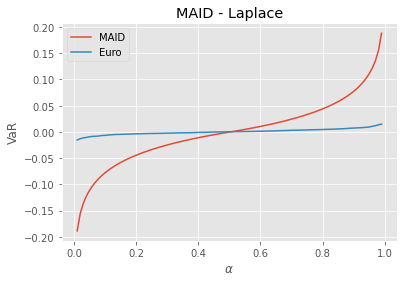

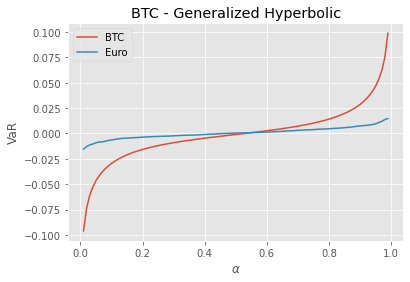

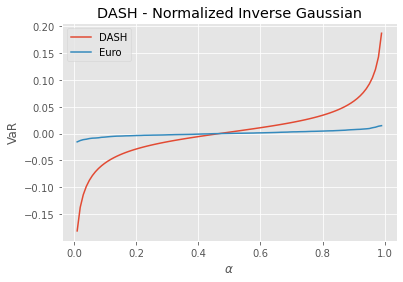

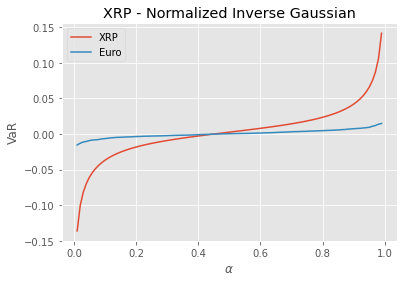

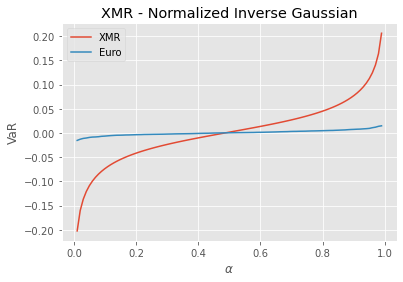

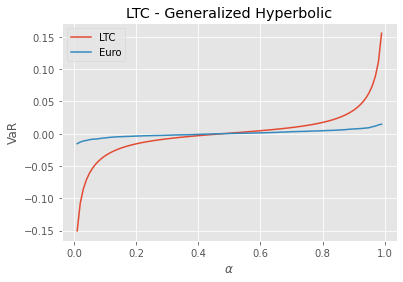

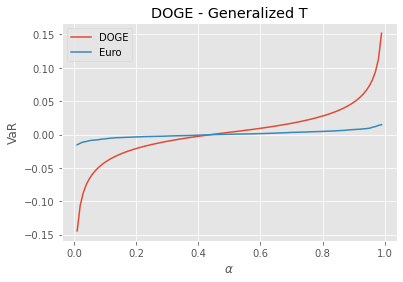

In [34]:
for coin, dist in best_dists.items():
    pydist = info_df[(info_df['coin'] == coin) & (
        info_df['dist'] == dist)]['pydist'].iloc[0]

    def quantile(x): return np.vectorize(pydist.quantile)(x)
    var = quantile(q)
    fig, ax = plt.subplots()
    ax.plot(q, var, label=coin)
    plt.plot(q, euro_quantile, label = 'Euro')
    ax.set_title(f"{coin} - {pydist.name}")
    ax.set_ylabel('VaR')
    ax.set_xlabel(r'$\alpha$')

    plt.legend();
    #plt.savefig(f'../plots/var/{coin}_var.eps')
    plt.show()


### ES Plots

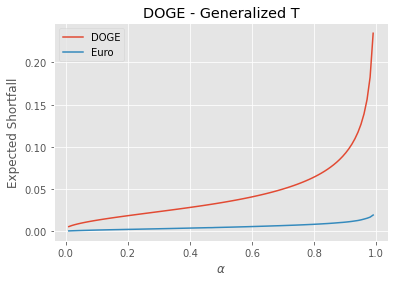

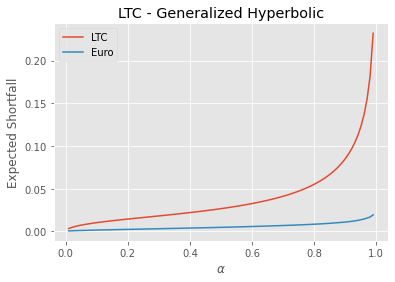

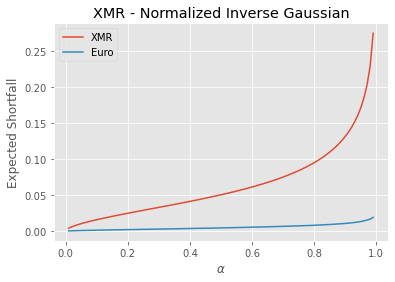

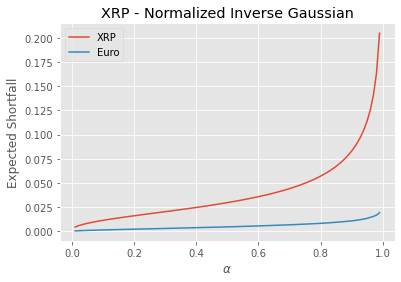

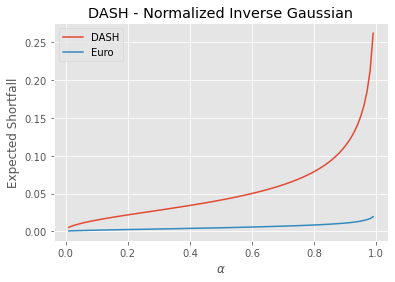

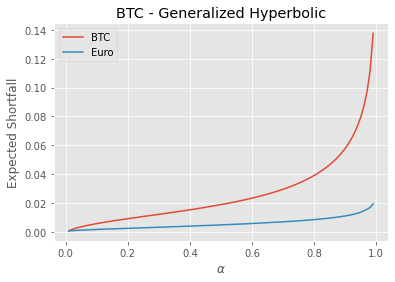

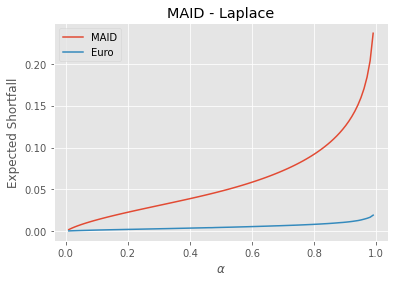

In [35]:
def empirical_es(var, data):
    return np.sum(np.multiply(data >= var, data))/np.sum(data >= var)


empirical_es_euro = [empirical_es(
    var, euro['log_return'].dropna()) for var in euro_quantile]

for coin, dist in reversed(best_dists.items()):
    pydist = info_df[(info_df['coin'] == coin) & (
        info_df['dist'] == dist)]['pydist'].iloc[0]

    es_func = lambda x: np.vectorize(pydist.expected_shortfall)(x)

    es = es_func(q)
    fig, ax = plt.subplots()
    ax.plot(q, es, label=coin)
    ax.plot(q, empirical_es_euro, label = 'Euro')

    ax.set_ylabel('Expected Shortfall')
    ax.set_xlabel(r'$\alpha$')

    ax.set_title(f"{coin} - {pydist.name}")
    plt.legend()
    #plt.savefig(f'../plots/es/{coin}_es.eps')
    plt.show();
